Script Description
Purpose:
This script reads CO2 emissions data from an Excel file and generates line plots for each specified transport mode, showing various metrics over time. It also calculates and displays yearly trend lines and compares the current values against the 2030 targets for each transport mode. Additionally, the script handles an "ALL MODES" scenario by aggregating data across all transport modes.

Input:
The script expects an Excel file with the following columns:

Leg Transport Mode: The mode of transport (e.g., AIR, ROA, SEA, etc.).
Service Completion Month: The month of service completion.
Service Completion Year: The year of service completion.
TKm: Tonnes-kilometer of transport.
CO2eq (tonnes): CO2 equivalent in tonnes.
CO2eq After Reduction: CO2 equivalent after reduction measures in tonnes.
CO2eq/TKm (g): CO2 equivalent per tonne-kilometer in grams.
CO2eq/TKm (g) After Reduction: CO2 equivalent per tonne-kilometer after reduction measures in grams.
Output:
The script generates and saves line plots as PNG files for each transport mode, showing:

The specified metric (e.g., TKm, CO2eq After Reduction, CO2eq/TKm (g) After Reduction) over time.
Yearly trend lines with percentage change.
A horizontal line indicating the 2030 target for each transport mode.
The current value of the specified metric in the title of the plot.
Each plot is saved with a descriptive filename, indicating the transport mode and the metric being plotted.

Steps:
Reading Data:

The script reads the Excel file into a pandas DataFrame.
Converts the Service Completion Month and Service Completion Year columns into a datetime format.
Aggregating Data for ALL MODES:

Sums the CO2eq and TKm values for all transport modes.
Calculates the combined CO2eq/TKm (g) After Reduction for ALL MODES.
Adds the aggregated data back to the original DataFrame.
Plotting:

For each transport mode, the script filters the data, sorts it by date, and generates line plots for the specified metrics.
Calculates and plots yearly trend lines, indicating the percentage change in the specified metric.
Adjusts the y-axis limits to ensure both the data and the 2030 target line are fully visible.
Draws a horizontal line at the 2030 target for CO2eq/TKm (g) After Reduction.
Saving and Displaying:

Each plot is saved as a PNG file with a descriptive filename.
The script also displays each plot for visual inspection.

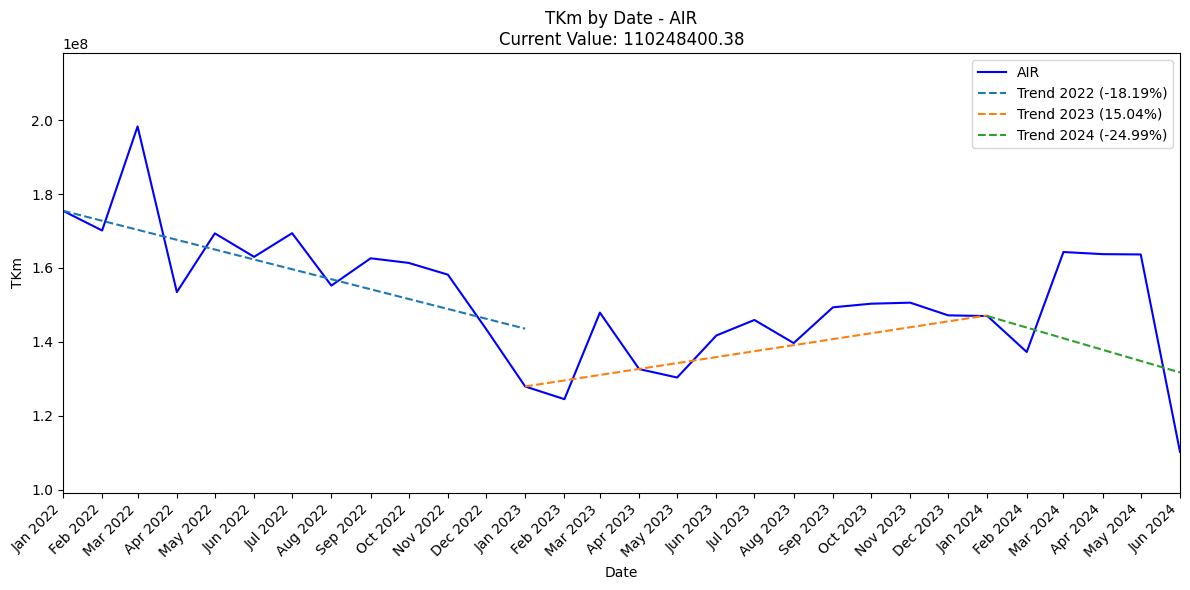

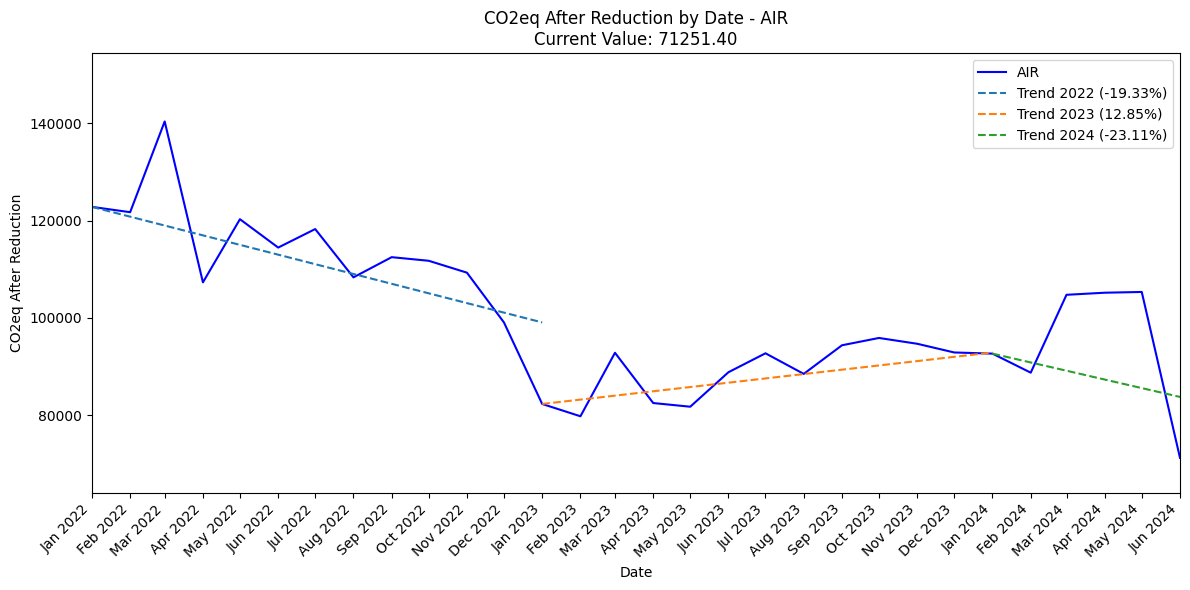

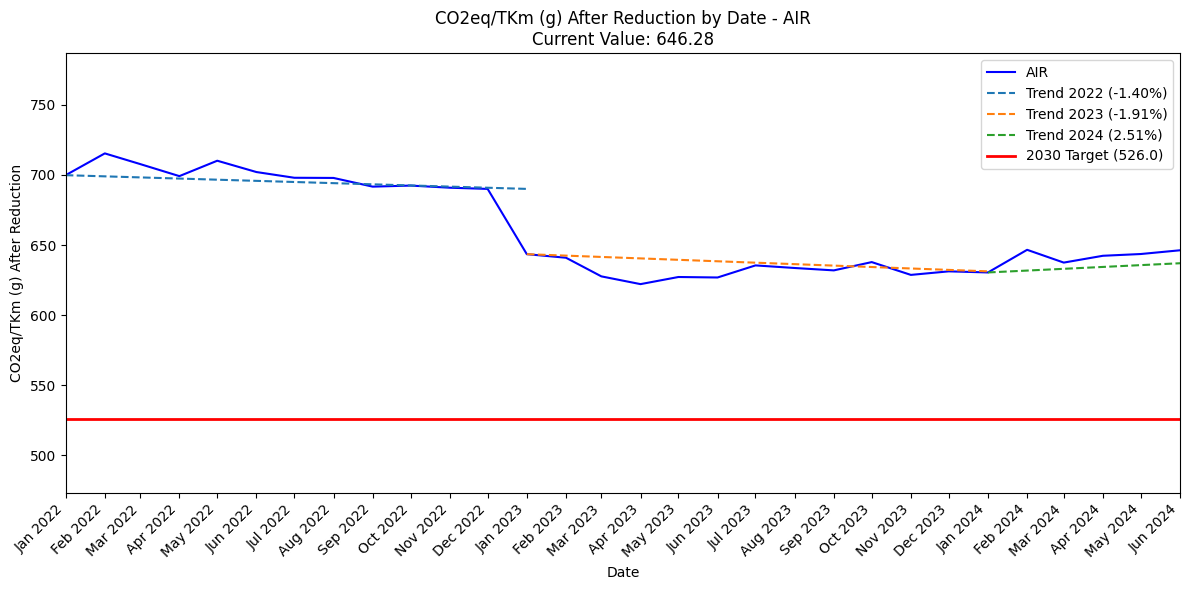

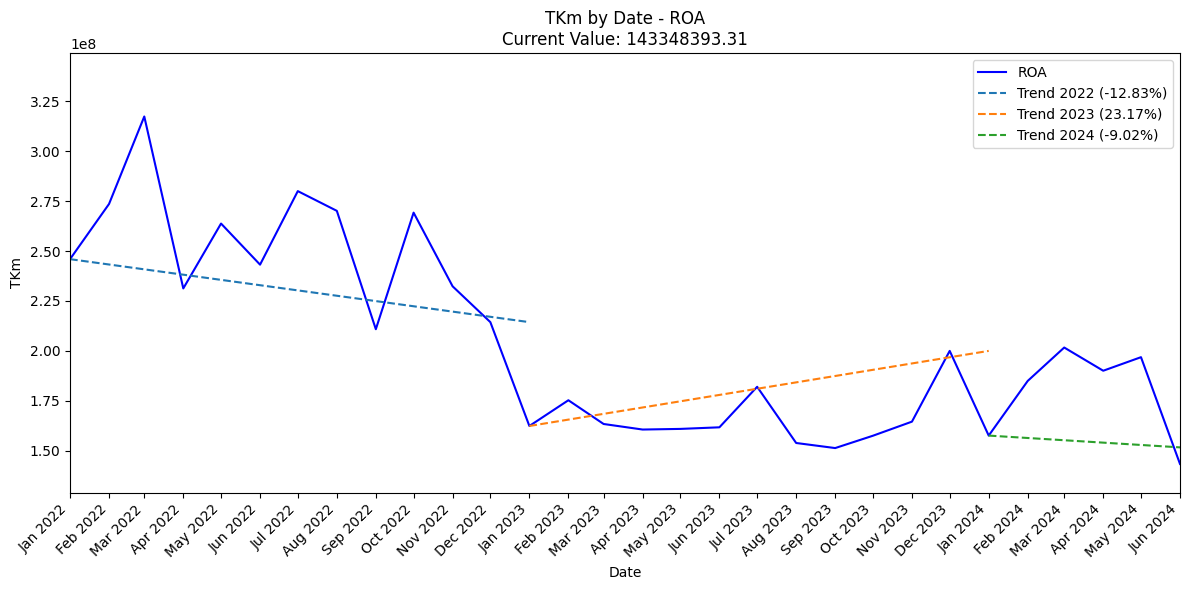

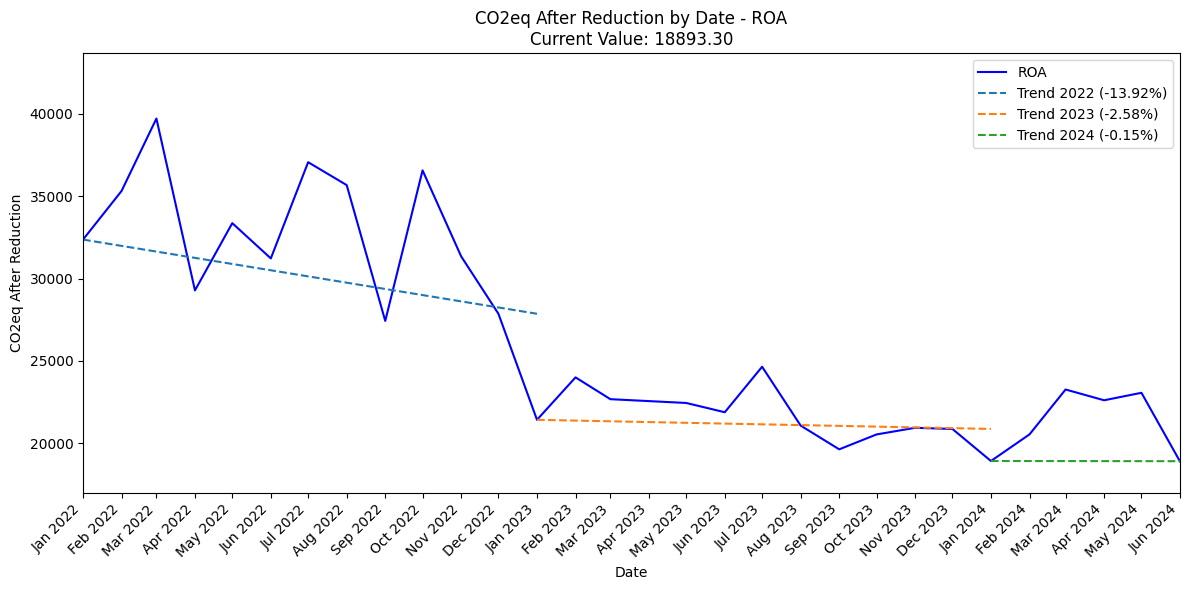

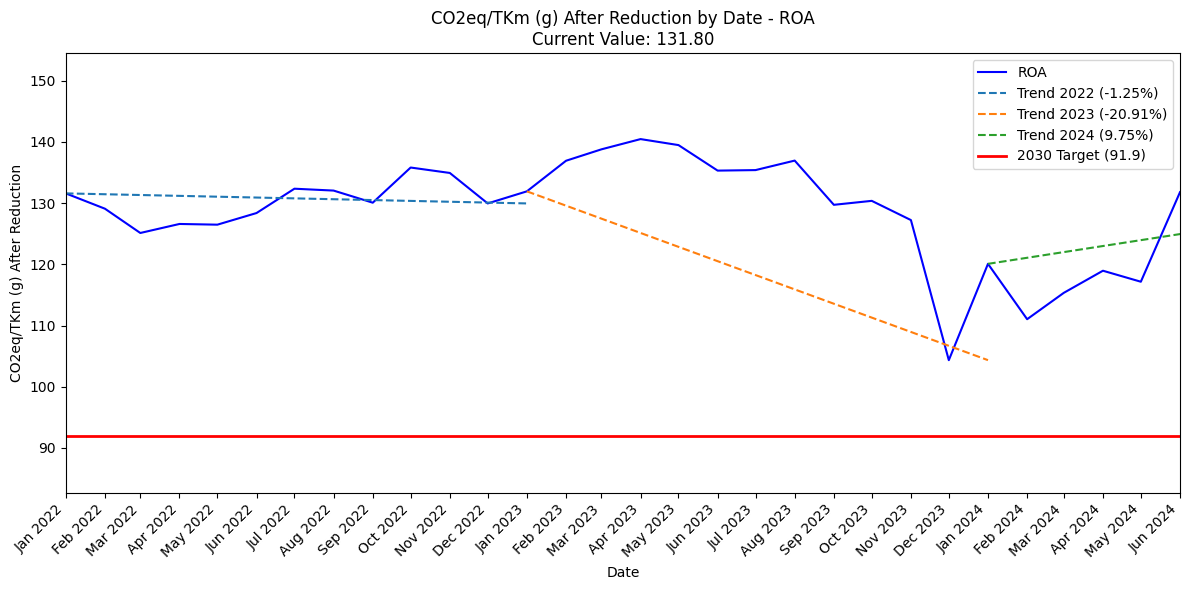

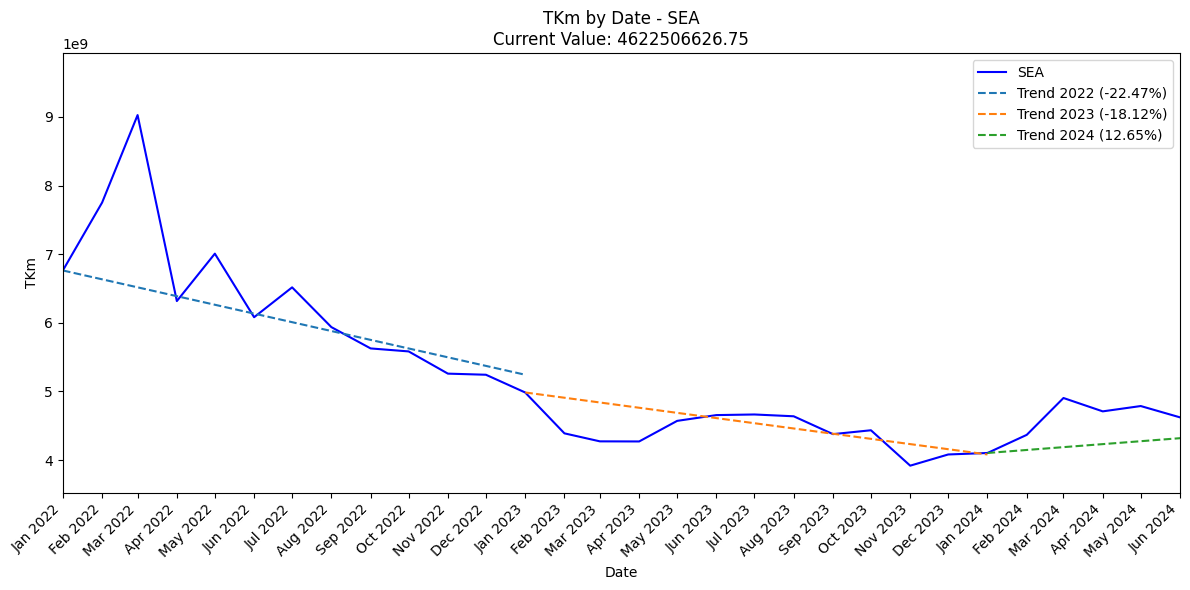

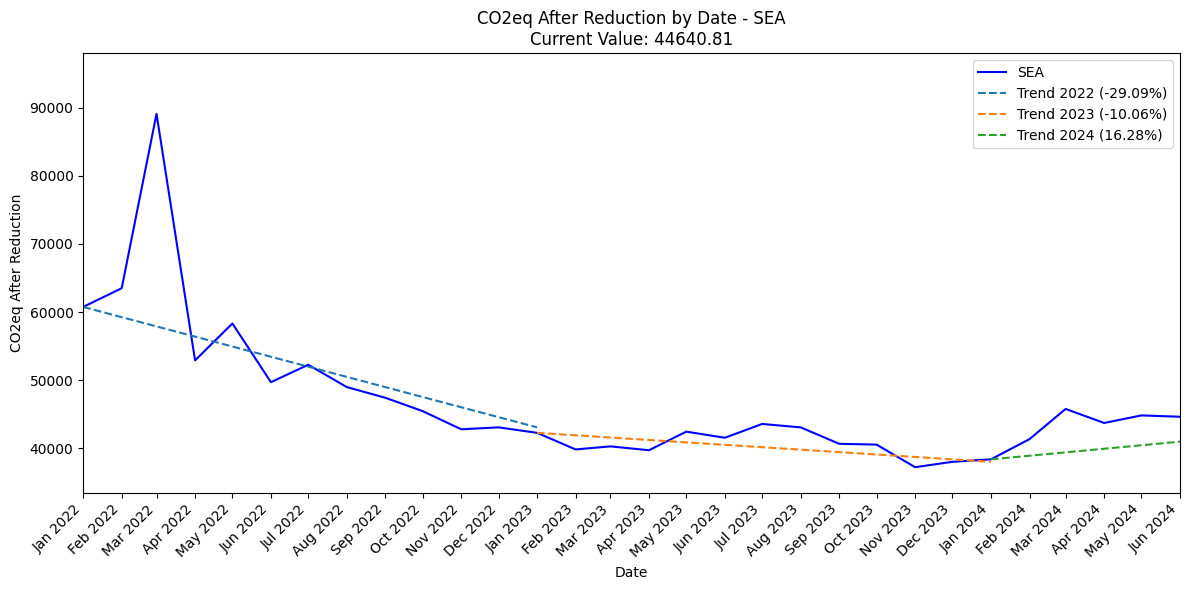

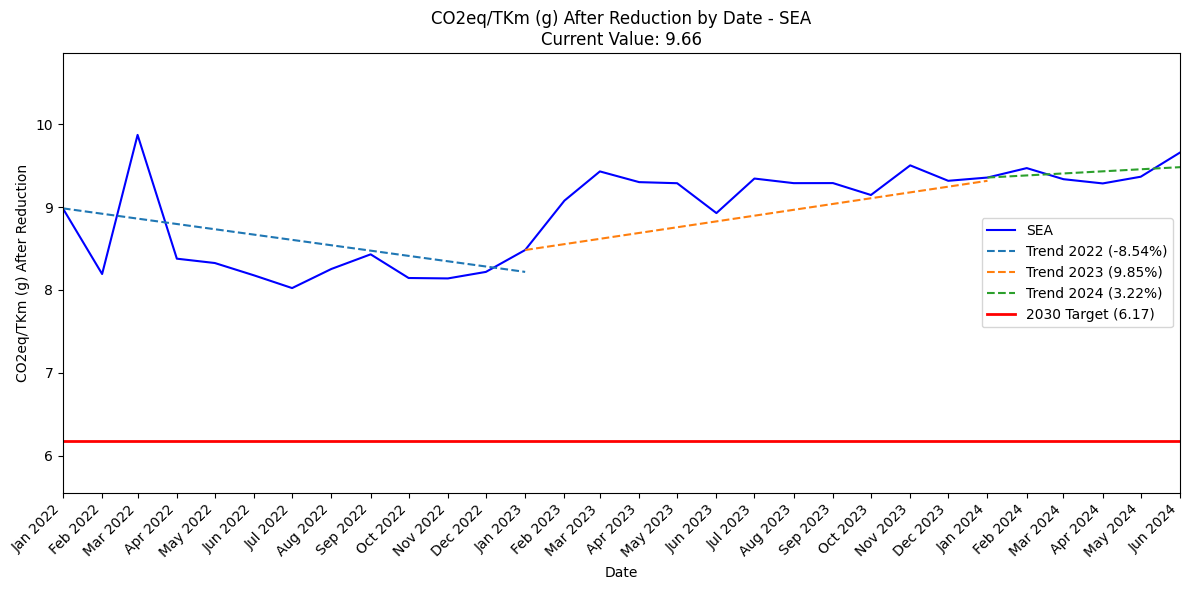

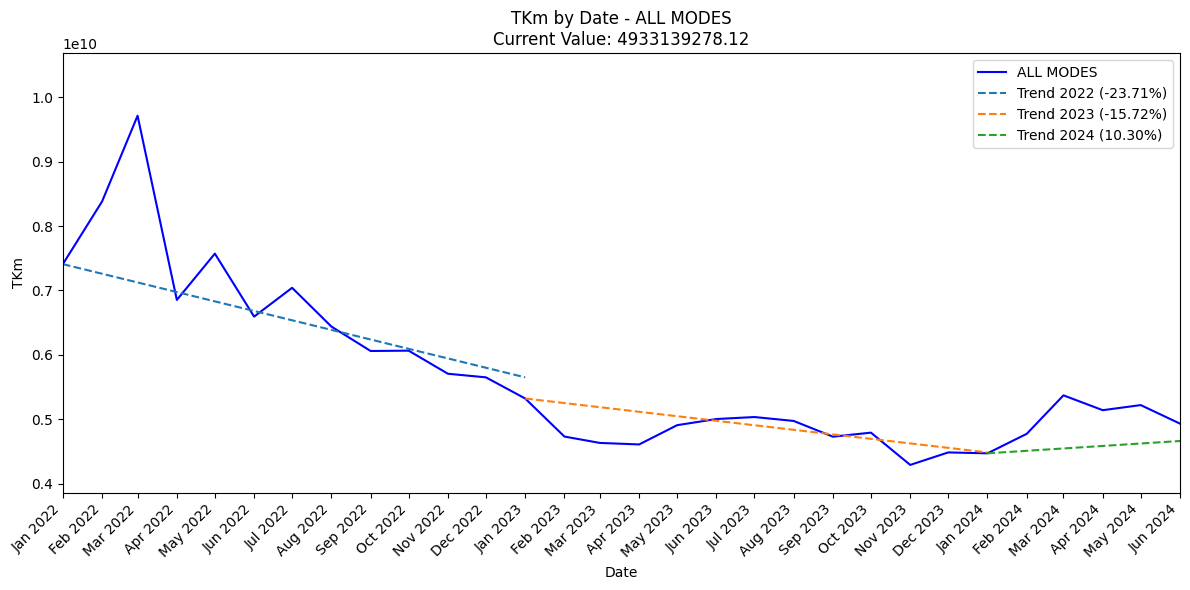

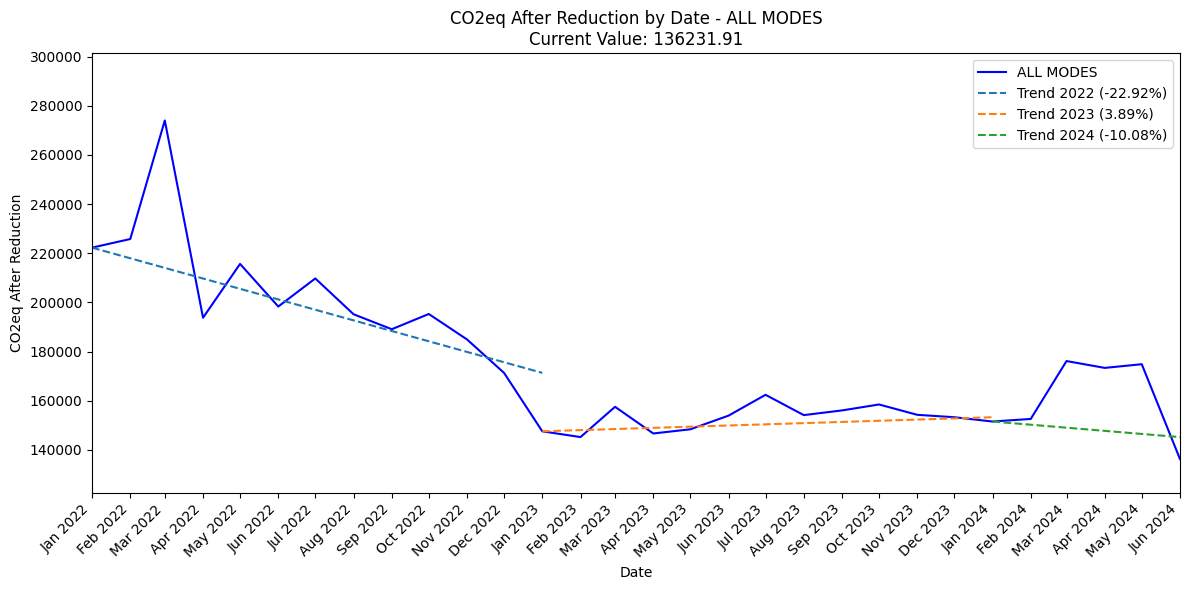

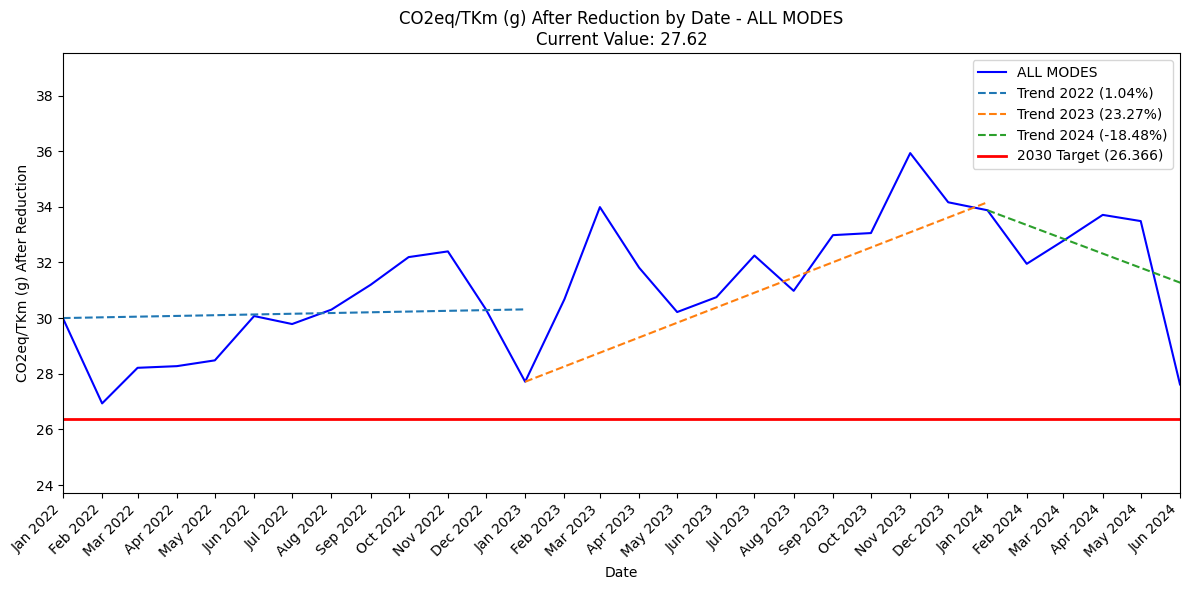

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Read the Excel file into a pandas DataFrame
df = pd.read_excel('input.xlsx')

# Convert 'Service Completion Month' and 'Service Completion Year' to datetime
df['Date'] = pd.to_datetime(df['Service Completion Month'].str[:3] + ' ' + df['Service Completion Year'].astype(str), format='%b %Y')

# Define the transport modes and their corresponding 2030 targets
transport_modes = ['AIR', 'ROA', 'SEA', 'ALL MODES']
targets = {'AIR': 526.0, 'ROA': 91.90, 'SEA': 6.17, 'ALL MODES': 26.366}

# Define the columns to plot
columns_to_plot = ['TKm', 'CO2eq After Reduction', 'CO2eq/TKm (g) After Reduction']

# Add a row for 'ALL MODES'
numeric_columns = ['TKm', 'CO2eq (tonnes)', 'CO2eq After Reduction']
df_all_modes = df.groupby(['Service Completion Month', 'Service Completion Year'])[numeric_columns].sum().reset_index()
df_all_modes['Leg Transport Mode'] = 'ALL MODES'
df_all_modes['Date'] = pd.to_datetime(df_all_modes['Service Completion Month'].str[:3] + ' ' + df_all_modes['Service Completion Year'].astype(str), format='%b %Y')

# Calculate combined CO2eq/TKm (g) After Reduction for ALL MODES
df_all_modes['CO2eq/TKm (g) After Reduction'] = (df_all_modes['CO2eq After Reduction'] * 1e6) / df_all_modes['TKm']

# Combine the all modes data back to the original dataframe
df = pd.concat([df, df_all_modes], ignore_index=True)

for mode in transport_modes:
    # Filter the data for the current transport mode
    mode_data = df[df['Leg Transport Mode'] == mode]
    
    # Sort the data by date
    mode_data = mode_data.sort_values('Date')
    
    for column in columns_to_plot:
        # Create a figure and subplot for the current transport mode and column
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot the line for the current transport mode and column
        ax.plot(mode_data['Date'], mode_data[column], label=mode, color=(0, 0, 1))
        
        # Calculate the maximum and minimum y-values for the current transport mode and column
        max_value = mode_data[column].max()
        min_value = mode_data[column].min()
        
        # Include the 2030 target in the y-axis limits if applicable
        if column == 'CO2eq/TKm (g) After Reduction' and mode in targets:
            target_value = targets[mode]
            max_value = max(max_value, target_value)
            min_value = min(min_value, target_value)
        
        # Set the x-axis limits to start from January 2022
        start_date = datetime(2022, 1, 1)
        end_date = mode_data['Date'].max()
        
        # Check if end_date is valid and adjust if necessary
        if pd.isna(end_date) or end_date < start_date:
            end_date = datetime.today()
        
        ax.set_xlim(left=start_date, right=end_date)
        
        # Generate x-axis ticks for each month
        months = pd.date_range(start=start_date, end=end_date, freq='MS')
        ax.set_xticks(months)
        
        # Set the x-axis label and format
        ax.set_xlabel('Date')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        
        # Set the y-axis label
        ax.set_ylabel(column)
        
        # Set the y-axis limits with padding to ensure visibility
        if pd.notna(max_value) and max_value > 0:
            ax.set_ylim(bottom=min_value * 0.9, top=max_value * 1.1)
        
        # Get the unique years in the data
        years = mode_data['Date'].dt.year.unique()
        
        # Plot the trend line for each year and calculate the percentage change
        for year in years:
            # Filter the data for the current year
            year_data = mode_data[(mode_data['Date'].dt.year == year)]
            
            # Check if year_data is empty
            if year_data.empty:
                continue
            
            # Get the start and end dates for the trend line
            start_date = datetime(year, 1, 1)
            end_date = datetime(year + 1, 1, 1)
            
            # Get the first and last values for the trend line
            start_value = year_data[column].iloc[0]
            end_value = year_data[column].iloc[-1]
            
            # Calculate the percentage change
            percentage_change = (end_value - start_value) / start_value * 100
            
            # Plot the trend line with the percentage change
            ax.plot([start_date, end_date], [start_value, end_value], linestyle='--', label=f'Trend {year} ({percentage_change:.2f}%)')
        
        # Draw a horizontal line at the 2030 target only for 'CO2eq/TKm (g) After Reduction'
        if column == 'CO2eq/TKm (g) After Reduction' and mode in targets:
            ax.axhline(targets[mode], color='red', linestyle='-', linewidth=2, label=f'2030 Target ({targets[mode]})')
        
        # Get the current value
        if not mode_data[column].empty:
            current_value = mode_data[column].iloc[-1]
            # Set the subplot title with the current value
            ax.set_title(f'{column} by Date - {mode}\nCurrent Value: {current_value:.2f}')
        else:
            ax.set_title(f'{column} by Date - {mode}\nNo data available')
        
        # Add a legend
        ax.legend()
        
        # Rotate the x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Replace '/' with '_' in the column name for the filename
        filename = f'{mode}_{column.replace("/", "_").replace(" ", "_")}_plot.png'
        
        # Save the plot as an individual picture
        plt.tight_layout()
        plt.savefig(filename)
        
        # Display the plot
        plt.show()


Showing both CO2 emissions per tonne-kilometer (g) and CO2 emissions per tonne-kilometer after reduction.


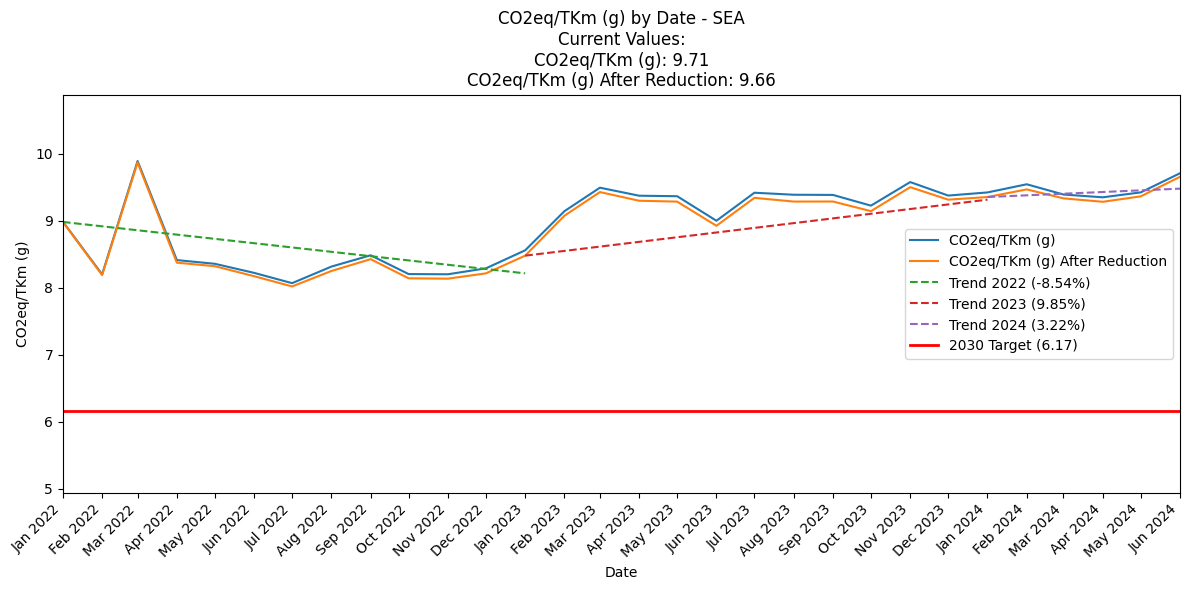

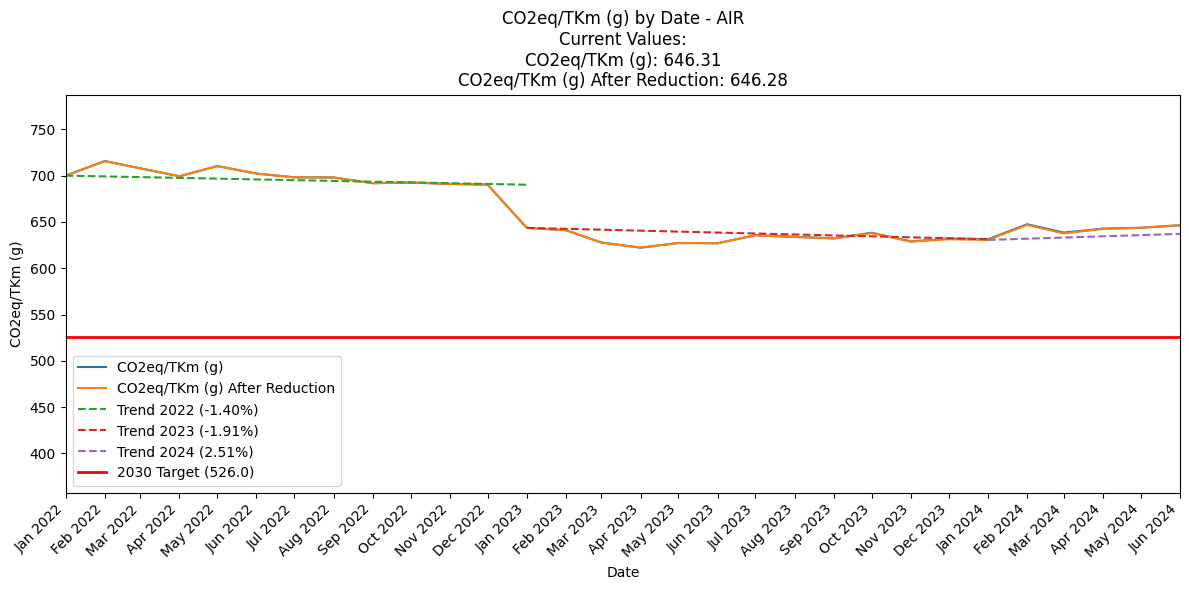

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Read the Excel file into a pandas DataFrame
df = pd.read_excel('input.xlsx')

# Convert 'Service Completion Month' and 'Service Completion Year' to datetime
df['Date'] = pd.to_datetime(df['Service Completion Month'].str[:3] + ' ' + df['Service Completion Year'].astype(str), format='%b %Y')

# Define the transport modes and their corresponding 2030 targets
transport_modes = ['SEA', 'AIR']
targets = {'SEA': 6.17, 'AIR': 526.0}

# Define the columns to plot
columns_to_plot = ['CO2eq/TKm (g)', 'CO2eq/TKm (g) After Reduction']

for mode in transport_modes:
    # Filter the data for the current transport mode
    mode_data = df[df['Leg Transport Mode'] == mode]
    
    # Sort the data by date
    mode_data = mode_data.sort_values('Date')
    
    # Create a figure and subplot for the current transport mode
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for column in columns_to_plot:
        # Plot the line for the current transport mode and column
        ax.plot(mode_data['Date'], mode_data[column], label=column)
    
    # Calculate the maximum y-value across both columns
    max_value = mode_data[columns_to_plot].max().max()
    
    # Set the x-axis limits to start from January 2022
    start_date = datetime(2022, 1, 1)
    end_date = mode_data['Date'].max()
    ax.set_xlim(left=start_date, right=end_date)
    
    # Generate x-axis ticks for each month
    months = pd.date_range(start=start_date, end=end_date, freq='MS')
    ax.set_xticks(months)
    
    # Set the x-axis label and format
    ax.set_xlabel('Date')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    # Set the y-axis label
    ax.set_ylabel('CO2eq/TKm (g)')
    
    # Set the y-axis limits to 50% of the maximum value and add some space on top
    ax.set_ylim(bottom=max_value * 0.5, top=max_value * 1.1)
    
    # Get the unique years in the data
    years = mode_data['Date'].dt.year.unique()
    
    # Plot the trend line for each year and calculate the percentage change for 'CO2eq/TKm (g) After Reduction'
    for year in years:
        # Filter the data for the current year
        year_data = mode_data[(mode_data['Date'].dt.year == year)]
        
        # Get the start and end dates for the trend line
        start_date = datetime(year, 1, 1)
        end_date = datetime(year + 1, 1, 1)
        
        # Get the first and last values for the trend line
        start_value = year_data['CO2eq/TKm (g) After Reduction'].iloc[0]
        end_value = year_data['CO2eq/TKm (g) After Reduction'].iloc[-1]
        
        # Calculate the percentage change
        percentage_change = (end_value - start_value) / start_value * 100
        
        # Plot the trend line with the percentage change
        ax.plot([start_date, end_date], [start_value, end_value], linestyle='--', label=f'Trend {year} ({percentage_change:.2f}%)')
    
    # Draw a horizontal line at the 2030 target
    ax.axhline(targets[mode], color='red', linestyle='-', linewidth=2, label=f'2030 Target ({targets[mode]})')
    
    # Get the current values for both columns
    current_values = mode_data[columns_to_plot].iloc[-1]
    
    # Set the subplot title with the current values
    ax.set_title(f'CO2eq/TKm (g) by Date - {mode}\nCurrent Values:\n' + '\n'.join([f'{col}: {val:.2f}' for col, val in current_values.items()]))
    
    # Add a legend
    ax.legend()
    
    # Rotate the x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Save the plot as an individual picture
    plt.tight_layout()
    plt.savefig(f'{mode}_CO2eq_per_TKm_SF.png')
    
    # Display the plot
    plt.show()

CREATE 3 TABLES IN EXCEL TKM, CO2E TOTALS, CO2E/TKM

In [6]:
import pandas as pd

# Read the Excel file into a pandas DataFrame
df = pd.read_excel('input.xlsx')

# Convert 'Service Completion Month' and 'Service Completion Year' to datetime
df['Date'] = pd.to_datetime(df['Service Completion Month'].str[:3] + ' ' + df['Service Completion Year'].astype(str), format='%b %Y')

# Ensure 'TKm' and 'CO2eq/TKm (g)' are numeric
df['TKm'] = pd.to_numeric(df['TKm'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')
df['CO2eq (tonnes)'] = pd.to_numeric(df['CO2eq (tonnes)'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')
df['CO2eq After Reduction'] = pd.to_numeric(df['CO2eq After Reduction'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')

# Set the aggregation period: 'Q1', 'Q2', 'Q3', or 'Q4'
aggregation_period = 'Q2'

# Define the months to include based on the aggregation period
if aggregation_period == 'Q1':
    months_to_include = [1, 2, 3]
elif aggregation_period == 'Q2':
    months_to_include = [1, 2, 3, 4, 5, 6]
elif aggregation_period == 'Q3':
    months_to_include = [1, 2, 3, 4, 5, 6, 7, 8, 9]
else:
    months_to_include = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Filter the data based on the selected aggregation period
df['Month'] = df['Date'].dt.month
df_filtered = df[df['Month'].isin(months_to_include)]

# Function to summarize data for a given year
def summarize_data(df, year):
    summary = df[df['Service Completion Year'] == year].groupby('Leg Transport Mode').agg({
        'TKm': 'sum',
        'CO2eq (tonnes)': 'sum',
        'CO2eq After Reduction': 'sum'
    }).reset_index()

    summary['CO2eq/TKm (g)'] = (summary['CO2eq (tonnes)'] * 1e6) / summary['TKm']
    summary['CO2eq/TKm (g) After Reduction'] = (summary['CO2eq After Reduction'] * 1e6) / summary['TKm']

    summary.columns = [f'{col} {year}' if col != 'Leg Transport Mode' else col for col in summary.columns]
    return summary

# Summarize data for 2022, 2023, and 2024
summary_2022 = summarize_data(df_filtered, 2022)
summary_2023 = summarize_data(df_filtered, 2023)
summary_2024 = summarize_data(df_filtered, 2024)

# Merge the summaries
summary = pd.merge(summary_2024, summary_2023, on='Leg Transport Mode', how='outer', suffixes=('_2024', '_2023'))
summary = pd.merge(summary, summary_2022, on='Leg Transport Mode', how='outer', suffixes=('', '_2022'))

# Calculate absolute and relative changes
summary['Absolute Change TKm'] = summary['TKm 2024'] - summary['TKm 2023']
summary['Relative Change TKm (%)'] = (summary['Absolute Change TKm'] / summary['TKm 2023']) * 100

summary['Absolute Change CO2eq After Reduction'] = summary['CO2eq After Reduction 2024'] - summary['CO2eq After Reduction 2023']
summary['Relative Change CO2eq After Reduction (%)'] = (summary['Absolute Change CO2eq After Reduction'] / summary['CO2eq After Reduction 2023']) * 100

summary['Absolute Change CO2eq/TKm (g) After Reduction'] = summary['CO2eq/TKm (g) After Reduction 2024'] - summary['CO2eq/TKm (g) After Reduction 2023']
summary['Relative Change CO2eq/TKm (g) After Reduction (%)'] = (summary['Absolute Change CO2eq/TKm (g) After Reduction'] / summary['CO2eq/TKm (g) After Reduction 2023']) * 100

# Calculate totals for each table
totals = {
    'Leg Transport Mode': 'All modes',
    'TKm 2024': summary['TKm 2024'].sum(),
    'TKm 2023': summary['TKm 2023'].sum(),
    'TKm 2022': summary['TKm 2022'].sum(),
    'Absolute Change TKm': summary['Absolute Change TKm'].sum(),
    'Relative Change TKm (%)': (summary['Absolute Change TKm'].sum() / summary['TKm 2023'].sum()) * 100,
    'CO2eq After Reduction 2024': summary['CO2eq After Reduction 2024'].sum(),
    'CO2eq After Reduction 2023': summary['CO2eq After Reduction 2023'].sum(),
    'CO2eq After Reduction 2022': summary['CO2eq After Reduction 2022'].sum(),
    'Absolute Change CO2eq After Reduction': summary['Absolute Change CO2eq After Reduction'].sum(),
    'Relative Change CO2eq After Reduction (%)': (summary['Absolute Change CO2eq After Reduction'].sum() / summary['CO2eq After Reduction 2023'].sum()) * 100,
    'CO2eq/TKm (g) After Reduction 2024': (summary['CO2eq After Reduction 2024'].sum() * 1e6) / summary['TKm 2024'].sum(),
    'CO2eq/TKm (g) After Reduction 2023': (summary['CO2eq After Reduction 2023'].sum() * 1e6) / summary['TKm 2023'].sum(),
    'CO2eq/TKm (g) After Reduction 2022': (summary['CO2eq After Reduction 2022'].sum() * 1e6) / summary['TKm 2022'].sum(),
    'Absolute Change CO2eq/TKm (g) After Reduction': ((summary['CO2eq After Reduction 2024'].sum() * 1e6) / summary['TKm 2024'].sum()) - ((summary['CO2eq After Reduction 2023'].sum() * 1e6) / summary['TKm 2023'].sum()),
    'Relative Change CO2eq/TKm (g) After Reduction (%)': (((summary['CO2eq After Reduction 2024'].sum() * 1e6) / summary['TKm 2024'].sum()) - ((summary['CO2eq After Reduction 2023'].sum() * 1e6) / summary['TKm 2023'].sum())) / ((summary['CO2eq After Reduction 2023'].sum() * 1e6) / summary['TKm 2023'].sum()) * 100
}

# Append totals row to each DataFrame
summary_totals = pd.DataFrame(totals, index=[0])
tonne_km_df = pd.concat([summary[['Leg Transport Mode', 'TKm 2024', 'TKm 2023', 'TKm 2022', 'Absolute Change TKm', 'Relative Change TKm (%)']], summary_totals[['Leg Transport Mode', 'TKm 2024', 'TKm 2023', 'TKm 2022', 'Absolute Change TKm', 'Relative Change TKm (%)']]], ignore_index=True)
co2e_tonnes_df = pd.concat([summary[['Leg Transport Mode', 'CO2eq After Reduction 2024', 'CO2eq After Reduction 2023', 'CO2eq After Reduction 2022', 'Absolute Change CO2eq After Reduction', 'Relative Change CO2eq After Reduction (%)']], summary_totals[['Leg Transport Mode', 'CO2eq After Reduction 2024', 'CO2eq After Reduction 2023', 'CO2eq After Reduction 2022', 'Absolute Change CO2eq After Reduction', 'Relative Change CO2eq After Reduction (%)']]], ignore_index=True)
co2e_per_tonne_km_df = pd.concat([summary[['Leg Transport Mode', 'CO2eq/TKm (g) After Reduction 2024', 'CO2eq/TKm (g) After Reduction 2023', 'CO2eq/TKm (g) After Reduction 2022', 'Absolute Change CO2eq/TKm (g) After Reduction', 'Relative Change CO2eq/TKm (g) After Reduction (%)']], summary_totals[['Leg Transport Mode', 'CO2eq/TKm (g) After Reduction 2024', 'CO2eq/TKm (g) After Reduction 2023', 'CO2eq/TKm (g) After Reduction 2022', 'Absolute Change CO2eq/TKm (g) After Reduction', 'Relative Change CO2eq/TKm (g) After Reduction (%)']]], ignore_index=True)

# Write the dataframes to an Excel file with each table on a separate sheet
output_file = f'key_tables_{aggregation_period}.xlsx'
with pd.ExcelWriter(output_file) as writer:
    tonne_km_df.to_excel(writer, sheet_name='TonneKm', index=False)
    co2e_tonnes_df.to_excel(writer, sheet_name='CO2e_tonnes', index=False)
    co2e_per_tonne_km_df.to_excel(writer, sheet_name='CO2e_tonneKm_g', index=False)

print(f"Tables have been created and saved to '{output_file}'.")


Tables have been created and saved to 'key_tables_Q2.xlsx'.
